In [1]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from hijri_converter import convert


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [2]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//RevenuePessengerDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_penumpang': 'y'}) #RENAME KOLOM REVENUE MENJADI y

#ADD features (year, month, week of year, week of month)
#Split the date into different components
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekofmonth'] = df['date'].apply(lambda d: (d.day - 1) // 7 + 1)
df['weekday'] = df['date'].dt.weekday
df['hijri'] = df['date'].apply(lambda d: convert.Gregorian(d.year, d.month, d.day).to_hijri())
df['hijri_month'] = df['hijri'].apply(lambda h: h.month)
df['hijri_day'] = df['hijri'].apply(lambda h: h.day)

# Drop the original date column
# df = df.drop('date', axis=1)
df = df.set_index('date')
df = df.sort_index()
df = df.drop('hijri', axis =1 )

df

,y,org,kode_org,des,kode_des,day,month,year,weekofmonth,weekday,hijri_month,hijri_day
date,,,,,,,,,,,,
2022-12-01,798000,TUAL,949,AMBON,946,1,12,2022,1,3,5,7
2022-12-01,1659000,BENOA/DENPASAR,613,MAKASSAR,893,1,12,2022,1,3,5,7
2022-12-01,312000,BENOA/DENPASAR,613,MAKASSAR,893,1,12,2022,1,3,5,7
2022-12-01,1164000,KIJANG,251,MAUMERE,683,1,12,2022,1,3,5,7
2022-12-01,794000,SURABAYA,563,NATUNA,725,1,12,2022,1,3,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-10,1515000,AMBON,946,SURABAYA,563,10,6,2023,2,5,11,21
2023-06-10,2080000,MAKASSAR,893,TANJUNG PRIOK,431,10,6,2023,2,5,11,21
2023-06-11,505000,AMBON,946,SURABAYA,563,11,6,2023,2,6,11,22


In [3]:
data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
data = data.groupby(['year','month','day','weekofmonth','weekday','hijri_month','hijri_day'])['y'].sum()

data = pd.DataFrame(data)
data
# data = data.asfreq('d')
# data = data.interpolate(method='linear')
# data = data.fillna(0)
# result = seasonal_decompose(data['y'], model = 'additive')
# result.plot()

y
year month day weekofmonth weekday hijri_month hijri_day           
2022 12    1   1           3       5           7           20831000
           2   1           4       5           8           56151000
           3   1           5       5           9           45501000
           4   1           6       5           10         173075000
           5   1           0       5           11           6961000
...                                                             ...
2023 6     6   1           1       11          17           1584000
           7   1           2       11          18           2170000
           9   2           4       11          20           4068000
           10  2           5       11          21           2080000
           11  2           6       11          22           4920000

[183 rows x 1 columns]

In [4]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers using the IQR method
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data

y
year month day weekofmonth weekday hijri_month hijri_day           
2022 12    1   1           3       5           7           20831000
           2   1           4       5           8           56151000
           3   1           5       5           9           45501000
           4   1           6       5           10         173075000
           5   1           0       5           11           6961000
...                                                             ...
2023 6     6   1           1       11          17           1584000
           7   1           2       11          18           2170000
           9   2           4       11          20           4068000
           10  2           5       11          21           2080000
           11  2           6       11          22           4920000

[175 rows x 1 columns]

In [5]:
# Interpolate missing values
data_interpolated = data.interpolate()

# Check if there are any remaining missing values
print(data_interpolated.isnull().sum())

y    0
dtype: int64


In [6]:
len(data)

175

In [7]:
steps = 24
train = data[:-steps]
test  = data[-steps:]

In [8]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
scaled_train[:10]

array([[0.04420616],
       [0.12070224],
       [0.09763646],
       [0.37393632],
       [0.0141665 ],
       [0.39406311],
       [1.        ],
       [0.42816364],
       [0.23690611],
       [0.25407441]])

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
# We do the same thing, but now instead for 12 months
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
127/127 [==============================] - 3s 9ms/step - loss: 0.0677
Epoch 2/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0548
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0550
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0544
Epoch 5/50
127/127 [==============================] - 2s 12ms/step - loss: 0.0523
Epoch 6/50
127/127 [==============================] - 1s 11ms/step - loss: 0.0499
Epoch 7/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0509
Epoch 8/50
127/127 [==============================] - 1s 11ms/step - loss: 0.0514
Epoch 9/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0483
Epoch 10/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0490
Epoch 11/50
127/127 [==============================] - 1s 8ms/step - loss: 0.0488
Epoch 12/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0473
Epoch 13/50
127/127

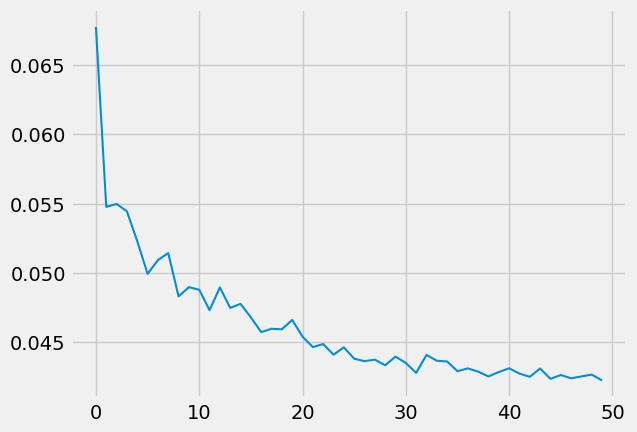

In [15]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [16]:
last_train_batch = scaled_train[-steps:]

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

1/1 [==============================] - 1s 549ms/step


array([[0.31619462]], dtype=float32)

In [17]:
scaled_test[0]

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [18]:
test_predictions

[array([0.31619462], dtype=float32),
 array([0.34897095], dtype=float32),
 array([0.37589812], dtype=float32),
 array([0.39260906], dtype=float32),
 array([0.39842042], dtype=float32),
 array([0.39697567], dtype=float32),
 array([0.38986328], dtype=float32),
 array([0.38009146], dtype=float32),
 array([0.37102354], dtype=float32),
 array([0.36290827], dtype=float32),
 array([0.35785732], dtype=float32),
 array([0.35469362], dtype=float32),
 array([0.35390344], dtype=float32),
 array([0.35396588], dtype=float32),
 array([0.3550289], dtype=float32),
 array([0.35645753], dtype=float32),
 array([0.35828355], dtype=float32),
 array([0.359425], dtype=float32),
 array([0.36036062], dtype=float32),
 array([0.36084473], dtype=float32),
 array([0.3617869], dtype=float32),
 array([0.36204955], dtype=float32),
 array([0.36200485], dtype=float32),
 array([0.3615428], dtype=float32)]

In [19]:
test.head()

y
year month day weekofmonth weekday hijri_month hijri_day           
2023 5     13  2           5       10          23         216496000
           14  2           6       10          24         182464000
           15  3           0       10          25         129259000
           16  3           1       10          26         106448000
           17  3           2       10          27          68643000

In [20]:
true_predictions = scaler.inverse_transform(test_predictions)

In [21]:
test.loc[:, 'Predictions'] = true_predictions
test.head()

C:\Users\khali\AppData\Local\Temp\ipykernel_10448\1567470468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predictions'] = true_predictions


y   
year month day weekofmonth weekday hijri_month hijri_day              
2023 5     13  2           5       10          23         216496000  \
           14  2           6       10          24         182464000   
           15  3           0       10          25         129259000   
           16  3           1       10          26         106448000   
           17  3           2       10          27          68643000   

                                                           Predictions  
year month day weekofmonth weekday hijri_month hijri_day                
2023 5     13  2           5       10          23         1.464143e+08  
           14  2           6       10          24         1.615479e+08  
           15  3           0       10          25         1.739808e+08  
           16  3           1       10          26         1.816966e+08  
           17  3           2       10          27         1.843799e+08

<Axes: xlabel='year,month,day,weekofmonth,weekday,hijri_month,hijri_day'>

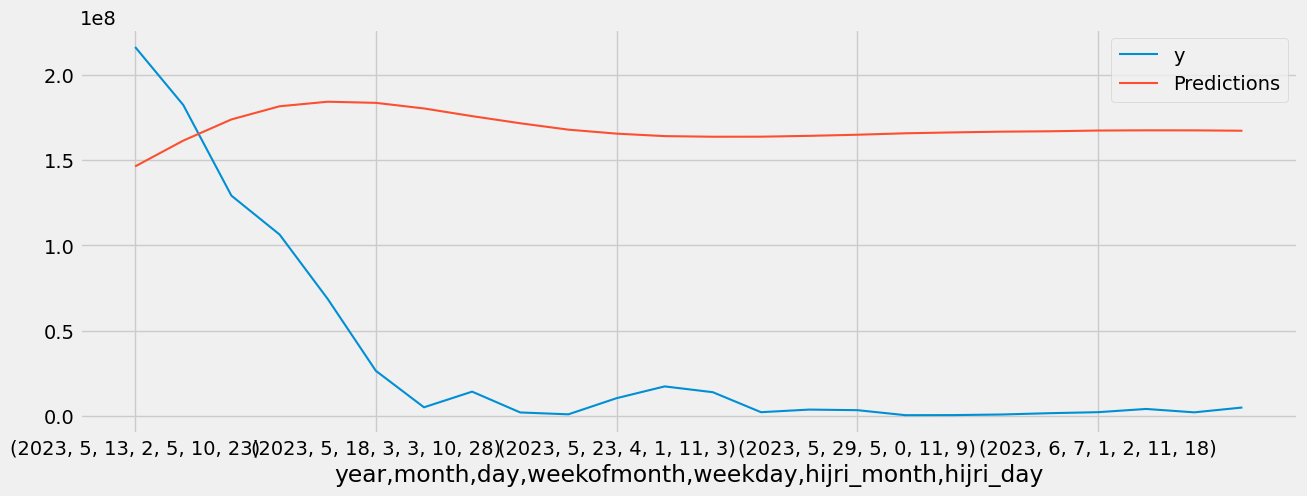

In [22]:
test.plot(figsize=(14,5))

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print("Root Mean Square Error (RMSE):", rmse) 
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Square Error (RMSE): 148415727.94447073
Mean Value of Test Dataset: 34136333.333333336
